In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text

In [2]:
meta_ana = pd.read_csv('SourceData/meta_exp_data.csv').set_index('RID')

### Define functions

In [3]:
# Apply log reg and return the model
def log_reg(compound, data):
    # Define data
    X = data[[compound, 'AGE', 'PTGENDER', 'APOE4', 'PTEDUCAT']].copy()
    X = sm.add_constant(X)
    y = data['DX.bl']

    try:
        model = sm.Logit(y, X).fit(disp=0)
        return(model)

    except Exception as e:
        print(f"Model fitting failed for {compound}: {e}")
        return(None)

In [4]:
# Return parameters for the model
def extract_protein_stats(compound, model):

    coef = model.params[compound]
    pval = model.pvalues[compound]
    stderr = model.bse[compound]
    tvalue = model.tvalues[compound]

    return({'Compound': compound,
            'Estimate': coef,
            'StdErr': stderr,
            'z_score': tvalue,      # zscore and t-value are same in results
            'p_value': pval
            })


In [5]:
# Compute AUC for the model
def compute_protein_auc(compound, model, data):
    # Define data
    X = data[[compound, 'AGE', 'PTGENDER', 'APOE4', 'PTEDUCAT']]
    X = sm.add_constant(X)
    y = data['DX.bl']

    try:
        y_pred_prob = model.predict(X)
        return(roc_auc_score(y, y_pred_prob))

    except Exception as e:
        print(f"AUC calculation failed for {compound}: {e}")
        return(None)

### CN vs AD

In [6]:
meta_ana_cn_ad = meta_ana[meta_ana['DX.bl'].str.contains('CN|AD', case=False, na=False)].copy()

# Binarization of gender for model
meta_ana_cn_ad['PTGENDER'] = meta_ana_cn_ad['PTGENDER'].map({'Male': 1, 'Female': 0})
meta_ana_cn_ad['DX.bl'] = meta_ana_cn_ad['DX.bl'].map({'AD': 1, 'CN': 0})

# Define columns
meta_cols = [col for col in meta_ana_cn_ad.columns if col.startswith('X')]

#### Sample entry

In [7]:
model = log_reg('X41', meta_ana_cn_ad)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  DX.bl   No. Observations:                  266
Model:                          Logit   Df Residuals:                      260
Method:                           MLE   Df Model:                            5
Date:                Tue, 27 May 2025   Pseudo R-squ.:                  0.2162
Time:                        10:57:18   Log-Likelihood:                -143.66
converged:                       True   LL-Null:                       -183.29
Covariance Type:            nonrobust   LLR p-value:                 1.199e-15
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7728      1.826     -1.519      0.129      -6.352       0.806
X41            0.0050      0.218      0.023      0.982      -0.423       0.433
AGE            0.0455      0.021      2.210      0.027       0.005       0.086
PTGENDER       0.2268      0.315      0.720      0.471      -0.390       0.844
APOE4          1.8088      0.253      7.149      0.000       1.313       2.305
PTEDUCAT      -0.1227      0.053     -2.313      0.021      -0.227      -0.019
==============================================================================
"""

In [8]:
extract_protein_stats('X41', model)

{'Compound': 'X41',
 'Estimate': 0.005035382079103786,
 'StdErr': 0.21827395490175716,
 'z_score': 0.023069092605987548,
 'p_value': 0.9815951596497237}

In [9]:
compute_protein_auc('X41',model, meta_ana_cn_ad)

0.8014249073810202

#### Application

In [10]:
logreg_results = []

for comp in meta_cols:
    model = log_reg(comp, meta_ana_cn_ad)
    stats = extract_protein_stats(comp, model)
    logreg_results.append(stats)

logreg_results = pd.DataFrame(logreg_results)

In [11]:
# fdr
rejected, pvals_corrected, _, _ = multipletests(logreg_results['p_value'], method='fdr_bh')
logreg_results['padj_fdr'] = pvals_corrected

# -log10(pval_fdr)
logreg_results['-log10(fdr)'] = -np.log10(logreg_results['padj_fdr'])

In [12]:
logreg_results

,Compound,Estimate,StdErr,z_score,p_value,padj_fdr,-log10(fdr)
0,X35,1.324896,0.455085,2.911317,0.003599,0.097895,1.009239
1,X41,0.005035,0.218274,0.023069,0.981595,0.990695,0.004060
2,X50,-0.078981,0.347507,-0.227278,0.820208,0.940013,0.026866
3,X55,-0.558756,0.319970,-1.746279,0.080763,0.350544,0.455258
4,X92,-0.117779,0.120443,-0.977882,0.328133,0.633640,0.198158
...,...,...,...,...,...,...,...
403,X999925936,-2.482907,0.763613,-3.251526,0.001148,0.074968,1.125127
404,X999925948,-1.130778,0.577529,-1.957960,0.050235,0.292797,0.533434
405,X999925957,-1.011248,0.640573,-1.578662,0.114414,0.432523,0.363991
406,X999925983,-0.399441,0.338607,-1.179660,0.238135,0.585166,0.232721


#### Volcano plot
Significance = abs(Estimate) > 0.5 and -log10(fdr) < 0.05

In [13]:
def assign_color(row):
    abs_est = abs(row['Estimate'])
    padj = row['padj_fdr']
    if abs_est > 0.5 and padj < 0.05:
        return 'red'  # significant + strong effect
    elif abs_est > 0.5 or padj < 0.05:
        return 'blue'  # either effect or significance
    else:
        return 'grey'

logreg_results['color'] = logreg_results.apply(assign_color, axis=1)

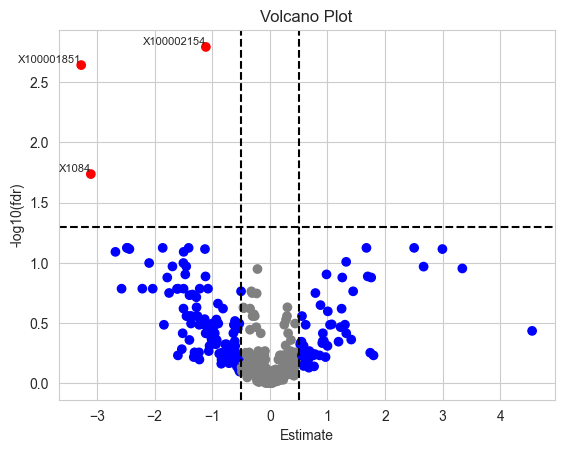

In [14]:
# colours
plt.scatter(logreg_results['Estimate'], logreg_results['-log10(fdr)'],c=logreg_results['color'])

# text
for _, row in logreg_results.iterrows():
    if row['color'] == 'red':
        plt.text(
            row['Estimate'],
            row['-log10(fdr)'],
            row['Compound'],
            fontsize=8,
            ha='right' if row['Estimate'] < 0 else 'left',
            va='bottom'
        )

# other notations
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--')
plt.axvline(x= 0.5, color='black', linestyle='--')
plt.axvline(x=-0.5, color='black', linestyle='--')
plt.xlabel('Estimate')
plt.ylabel('-log10(fdr)')
plt.title('Volcano Plot')
plt.show()

X100002154 = 100002154,Xenobiotics,Food Component/Plant,4894,NAMED,SSISHJJTAXXQAX-UHFFFAOYSA-N,S=C1NC(CC(C([O-])=O)[N+](C)(C)C)=CN1,ergothioneine,ergothioneine,58511-63-0,2297320,HMDB0003045,C05570,5351619,37459,400,156384,Pos Early,X100002154


X100001851 = 100001851,Amino Acid,"Glycine, Serine and Threonine Metabolism",11,NAMED,JJIHLJJYMXLCOY-BYPYZUCNSA-N,OC[C@@H](C(O)=O)NC(C)=O,N-acetylserine,N-acetylserine,97-14-3,58744,HMDB0002931,NA,65249,37076,305,147598,Polar,X100001851


X1084 = 1084,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",417,NAMED,IHYJTAOFMMMOPX-LURJTMIESA-N,O=C(O)[C@@H](NC(C)=O)C(C)C,N-acetylvaline,N-acetylvaline,96-81-1,60154,HMDB0011757,NA,66789,1591,209,124807,Neg,X1084

### MCI vs AD

#### Application

In [21]:
meta_ana_mci_ad = meta_ana[meta_ana['DX.bl'].str.contains('MCI|AD', case=False, na=False)].copy()

# Binarization of gender for model
meta_ana_mci_ad['PTGENDER'] = meta_ana_mci_ad['PTGENDER'].map({'Male': 1, 'Female': 0})
meta_ana_mci_ad['DX.bl'] = meta_ana_mci_ad['DX.bl'].map({'AD': 1, 'MCI': 0})

# Define columns
meta_cols = [col for col in meta_ana_mci_ad.columns if col.startswith('X')]

In [16]:
logreg_results = []

for comp in meta_cols:
    model = log_reg(comp, meta_ana_mci_ad)
    stats = extract_protein_stats(comp, model)
    logreg_results.append(stats)

logreg_results = pd.DataFrame(logreg_results)

In [17]:
# fdr
rejected, pvals_corrected, _, _ = multipletests(logreg_results['p_value'], method='fdr_bh')
logreg_results['padj_fdr'] = pvals_corrected

# -log10(pval_fdr)
logreg_results['-log10(fdr)'] = -np.log10(logreg_results['padj_fdr'])

In [18]:
logreg_results

,Compound,Estimate,StdErr,z_score,p_value,padj_fdr,-log10(fdr)
0,X35,0.615721,0.309885,1.986933,0.046930,0.491942,0.308086
1,X41,-0.063373,0.160642,-0.394495,0.693215,0.895038,0.048159
2,X50,-0.442718,0.258568,-1.712194,0.086861,0.588656,0.230138
3,X55,-0.374135,0.241799,-1.547299,0.121791,0.588656,0.230138
4,X92,0.024573,0.090661,0.271048,0.786354,0.916664,0.037790
...,...,...,...,...,...,...,...
403,X999925936,-1.073377,0.545802,-1.966604,0.049229,0.491942,0.308086
404,X999925948,-0.631776,0.436235,-1.448247,0.147548,0.604324,0.218730
405,X999925957,-0.848009,0.454730,-1.864862,0.062201,0.528707,0.276785
406,X999925983,0.121891,0.256345,0.475494,0.634435,0.867897,0.061532


#### Volcano plot
Significance = abs(Estimate) > 0.5 and -log10(fdr) < 0.05

In [19]:
def assign_color(row):
    abs_est = abs(row['Estimate'])
    padj = row['padj_fdr']
    if abs_est > 0.5 and padj < 0.05:
        return 'red'  # significant + strong effect
    elif abs_est > 0.5 or padj < 0.05:
        return 'blue'  # either effect or significance
    else:
        return 'grey'

logreg_results['color'] = logreg_results.apply(assign_color, axis=1)

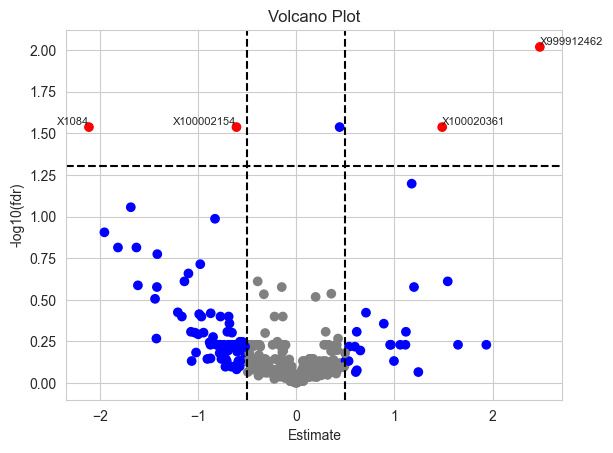

In [20]:
# colours
plt.scatter(logreg_results['Estimate'], logreg_results['-log10(fdr)'],c=logreg_results['color'])

# text
for _, row in logreg_results.iterrows():
    if row['color'] == 'red':
        plt.text(
            row['Estimate'],
            row['-log10(fdr)'],
            row['Compound'],
            fontsize=8,
            ha='right' if row['Estimate'] < 0 else 'left',
            va='bottom'
        )

# other notations
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--')
plt.axvline(x= 0.5, color='black', linestyle='--')
plt.axvline(x=-0.5, color='black', linestyle='--')
plt.xlabel('Estimate')
plt.ylabel('-log10(fdr)')
plt.title('Volcano Plot')
plt.show()

### MCI vs AD
#### Application
meta_ana_mci_ad = meta_ana[meta_ana['DX.bl'].str.contains('MCI|AD', case=False, na=False)].copy()

# Binarization of gender for model
meta_ana_mci_ad['PTGENDER'] = meta_ana_mci_ad['PTGENDER'].map({'Male': 1, 'Female': 0})
meta_ana_mci_ad['DX.bl'] = meta_ana_mci_ad['DX.bl'].map({'AD': 1, 'MCI': 0})

# Define columns
meta_cols = [col for col in meta_ana_mci_ad.columns if col.startswith('X')]
logreg_results = []

for comp in meta_cols:
    model = log_reg(comp, meta_ana_mci_ad)
    stats = extract_protein_stats(comp, model)
    logreg_results.append(stats)

logreg_results = pd.DataFrame(logreg_results)
# fdr
rejected, pvals_corrected, _, _ = multipletests(logreg_results['p_value'], method='fdr_bh')
logreg_results['padj_fdr'] = pvals_corrected

# -log10(pval_fdr)
logreg_results['-log10(fdr)'] = -np.log10(logreg_results['padj_fdr'])
logreg_results
#### Volcano plot
Significance = abs(Estimate) > 0.5 and -log10(fdr) < 0.05
def assign_color(row):
    abs_est = abs(row['Estimate'])
    padj = row['padj_fdr']
    if abs_est > 0.5 and padj < 0.05:
        return 'red'  # significant + strong effect
    elif abs_est > 0.5 or padj < 0.05:
        return 'blue'  # either effect or significance
    else:
        return 'grey'

logreg_results['color'] = logreg_results.apply(assign_color, axis=1)
# colours
plt.scatter(logreg_results['Estimate'], logreg_results['-log10(fdr)'],c=logreg_results['color'])

# text
for _, row in logreg_results.iterrows():
    if row['color'] == 'red':
        plt.text(
            row['Estimate'],
            row['-log10(fdr)'],
            row['Compound'],
            fontsize=8,
            ha='right' if row['Estimate'] < 0 else 'left',
            va='bottom'
        )

# other notations
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--')
plt.axvline(x= 0.5, color='black', linestyle='--')
plt.axvline(x=-0.5, color='black', linestyle='--')
plt.xlabel('Estimate')
plt.ylabel('-log10(fdr)')
plt.title('Volcano Plot')
plt.show()X999912462 - 999912462,NA,NA,NA,UNNAMED,NA,NA,X-12462,X-12462,NA,NA,NA,NA,NA,46620,400,157261,Pos Early,X999912462


X1090 - 1090,Cofactors and Vitamins,Hemoglobin and Porphyrin Metabolism,4409,NAMED,BPYKTIZUTYGOLE-KDUUSRDASA-N,CC(C(N\1)=O)=C(C=C)C1=C/C2=C(C)C(CCC(O)=O)=C(CC3=C(CCC(O)=O)C(C)=C(/C=C4NC(C(C=C)=C/4C)=O)N3)N2,"bilirubin (Z,Z)",bilirubin,635-65-4,4444055,HMDB0000054,C00486,5280352,43807,402,159596,Pos Late,X1090


X1084 -1084,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",417,NAMED,IHYJTAOFMMMOPX-LURJTMIESA-N,O=C(O)[C@@H](NC(C)=O)C(C)C,N-acetylvaline,N-acetylvaline,96-81-1,60154,HMDB0011757,NA,66789,1591,209,124807,Neg,X1084


X100020361 - 100020361,Amino Acid,Urea cycle; Arginine and Proline Metabolism,489,NAMED,YCCMTCQQDULIFE-UHFFFAOYSA-N,NC1CCCNC1=O,3-amino-2-piperidone,3-amino-2-piperidone,1892-22-4,4371576,HMDB0000323,NA,5200225,62853,400,220624,Pos Early,X100020361


X100002154 - 100002154,Xenobiotics,Food Component/Plant,4894,NAMED,SSISHJJTAXXQAX-UHFFFAOYSA-N,S=C1NC(CC(C([O-])=O)[N+](C)(C)C)=CN1,ergothioneine,ergothioneine,58511-63-0,2297320,HMDB0003045,C05570,5351619,37459,400,156384,Pos Early,X100002154

### CN vs MCI

#### Application

In [22]:
meta_ana_cn_mci = meta_ana[meta_ana['DX.bl'].str.contains('MCI|CN', case=False, na=False)].copy()

# Binarization of gender for model
meta_ana_cn_mci['PTGENDER'] = meta_ana_cn_mci['PTGENDER'].map({'Male': 1, 'Female': 0})
meta_ana_cn_mci['DX.bl'] = meta_ana_cn_mci['DX.bl'].map({'MCI': 1, 'CN': 0})

# Define columns
meta_cols = [col for col in meta_ana_cn_mci.columns if col.startswith('X')]

In [23]:
logreg_results = []

for comp in meta_cols:
    model = log_reg(comp, meta_ana_cn_mci)
    stats = extract_protein_stats(comp, model)
    logreg_results.append(stats)

logreg_results = pd.DataFrame(logreg_results)

In [24]:
# fdr
rejected, pvals_corrected, _, _ = multipletests(logreg_results['p_value'], method='fdr_bh')
logreg_results['padj_fdr'] = pvals_corrected

# -log10(pval_fdr)
logreg_results['-log10(fdr)'] = -np.log10(logreg_results['padj_fdr'])

In [25]:
logreg_results

,Compound,Estimate,StdErr,z_score,p_value,padj_fdr,-log10(fdr)
0,X35,0.439767,0.289653,1.518255,0.128950,0.817926,0.087286
1,X41,0.076665,0.147420,0.520044,0.603033,0.923957,0.034348
2,X50,0.318707,0.244927,1.301235,0.193178,0.817926,0.087286
3,X55,-0.085533,0.231456,-0.369543,0.711723,0.938755,0.027448
4,X92,-0.148026,0.087625,-1.689312,0.091160,0.817926,0.087286
...,...,...,...,...,...,...,...
403,X999925936,-0.739938,0.501253,-1.476176,0.139897,0.817926,0.087286
404,X999925948,-0.419899,0.404269,-1.038661,0.298962,0.864547,0.063212
405,X999925957,0.415201,0.441975,0.939422,0.347514,0.864547,0.063212
406,X999925983,-0.398751,0.253436,-1.573381,0.115631,0.817926,0.087286


#### Volcano plot
Significance = abs(Estimate) > 0.5 and -log10(fdr) < 0.05

In [26]:
def assign_color(row):
    abs_est = abs(row['Estimate'])
    padj = row['padj_fdr']
    if abs_est > 0.5 and padj < 0.05:
        return 'red'  # significant + strong effect
    elif abs_est > 0.5 or padj < 0.05:
        return 'blue'  # either effect or significance
    else:
        return 'grey'

logreg_results['color'] = logreg_results.apply(assign_color, axis=1)

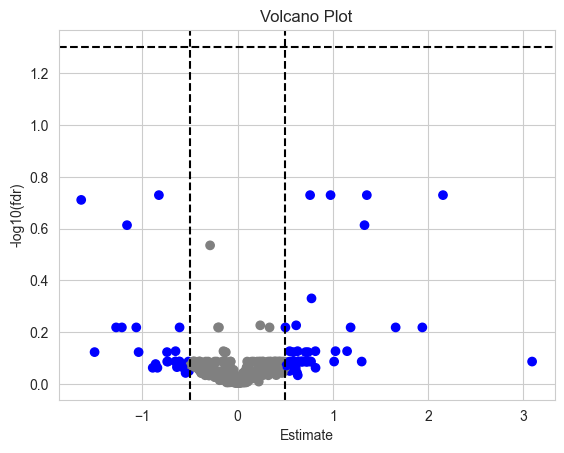

In [27]:
# colours
plt.scatter(logreg_results['Estimate'], logreg_results['-log10(fdr)'],c=logreg_results['color'])

# text
for _, row in logreg_results.iterrows():
    if row['color'] == 'red':
        plt.text(
            row['Estimate'],
            row['-log10(fdr)'],
            row['Compound'],
            fontsize=8,
            ha='right' if row['Estimate'] < 0 else 'left',
            va='bottom'
        )

# other notations
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--')
plt.axvline(x= 0.5, color='black', linestyle='--')
plt.axvline(x=-0.5, color='black', linestyle='--')
plt.xlabel('Estimate')
plt.ylabel('-log10(fdr)')
plt.title('Volcano Plot')
plt.show()